In [3]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
print("Done!")

Done!


In [4]:
"""Classes """
class rand_memory: #class for generating random numbers used as the amplitude of a signal
    def __init__(self, value=0):
        self.value=np.random.randint(low_amplitude, high_amplitude)


class markers: #this class is for counters used in generating the pulses
    def __init__(self, value=0):
        self.value=value
    def plus_one(self):
        self.value +=1


class conditions(): #This is used for knowing if a pulse is happening and the code will keep generating the pulse if the value is True
    def __init__(self, state=False):
        self.state=False
    def set_true(self):
        self.state=True
    def set_false(self):
        self.state=False

print("Done!")

Done!


In [5]:
"""Function """
#not used here
def display_stats(signal, t_axis, threshold, plot_size):
    if len(t_axis)%plot_size==0:

        print("plot n°: ", t_axis[-1] // plot_size)
        print("--------------------------------------------------------")

        plt.plot(t_axis[-plot_size:], signal[-plot_size:])
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (mV)")
        plt.axhline(y=threshold, color='r', lw=1, linestyle='--')
        plt.grid(True, lw=0.5)
        plt.title("Random signal and random pulses")
        plt.show()

def display_n_plots(t_axis,signals,n,threshold,plot_size):
    if t_axis[-1]%plot_size==0:
        print("plot n°: ", t_axis[-1] // plot_size)
        print("--------------------------------------------------------")
        fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # Adjust the figure size
        y_limits = (-250, 250)
        for i, ax in enumerate(axs.flat):
            ax.plot(t_axis[-plot_size:], signals[i][-plot_size:], label=f'Channel {i + 1}')
            ax.set_title(f'Channel {i + 1}', fontsize=10)
            ax.set_ylim(y_limits)
            ax.grid(True, lw=0.5)
            ax.label_outer()  # Only show outer labels to avoid redundancy
        fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title


        #plt.savefig(f'Figure {int(t_axis[-1] //200)+1} w 16 Controlled channels')
        plt.show()


def smart_append(t_axis,array,new_point,max_size):
    if t_axis[-1]<max_size:
        array=np.append(array,new_point)
    else:
        array=np.append(array[1:], new_point)
    return array


def create_n_pulses(n, likelihood, signal_limit,plot_size,conds, wave_counts ,amps ):

    pulses=[]
    for i in range(n):
        if conds[i].state==False:
            sig=0
            wave_counts[i].__init__()
            if np.random.randint(likelihood*plot_size)==1:
                conds[i].set_true()

        else:
            sig=burst_waveform(wave_counts[i].value, amps[i].value)
            #sig=amps[i].value
            wave_counts[i].plus_one()
            if wave_counts[i].value>signal_limit:
                conds[i].set_false()
                amps[i].__init__()

        pulses.append(sig)
    return np.sum(pulses)

def random_generator( mean, std_dev, conds,wave_counts, amps, likelihood,n, signal_limit):

    rand_point = np.random.normal(loc=mean, scale=std_dev) #this generates the background noise
    #rand_point=0

    signals=create_n_pulses(n, likelihood, signal_limit,plot_size,conds, wave_counts, amps) #this makes sure that the simulated signal is random and is able to have multiple superposed pulses.

    next_point= rand_point + signals

    return next_point

print("Done!")

Done!


In [63]:
"""This cell is for the L1 - L4 Trigger system"""
"""I will be dealing with signals[n] (from 0 to 15) as a  list of 16 channels"""

""" Channels 0 - 15: have special indices:
0:3 -- S1_Vtop, S1_Vbot, S2_Vtop, S2_Vbot
4:7 --  S3_Vtop, S3_Vbot, S4_Vtop, S4_Vbot
8:11 -- S1_Htop, S1_Hbot, S2_Htop, S2_Hbot
12:15 --  S3_Htop, S3_Hbot, S4_Htop, S4_Hbot
 """

"""For the list -L1- it has 15 binary values, the indices describe the L1 condition in that order"""

"""The list -Groups- is used to record the indices for L2; it has coordinates for the groups in this order:
S_1/2_|V|  ,  S_3/4_|V|  ,  S_1/2_|H|  ,  S_3/4_|H|
"""

"""The list -L2- is used to hold binary conditions of the states of the L2 triggers arranged in the same order as -Groups-"""

"""The list -L2_level- holds information about the level of trigger of L2;
level 1 if it is due to only one L1 trigger in the group;
level 2 if 2 L1 triggers in the group;
level 3 if 3 L1 triggers in the group
This information is held as an int
"""

"""The list -L3- is used to hold binary conditions of the states of the L3 triggers in this order
[0] is Vertical
[1] is Horizontal
"""

"""L4 is just one condition for the state of the L4 trigger"""

"""All The L1 states also have counters That make sure that the list keeps track of the progression and knows how long the window has been open"""

L1=[]
L1_counters=[]

Groups=[[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]]
L2=[]
L2_level=[]

L3=[]

L4=conditions()

#filling ip the lists with the classes
for i in range(16): #for all 16 L1 triggers
    L1.append(conditions())
    L1_counters.append(markers())

for i in range(4): #for all 4 L2 triggers
    L2.append(conditions())
    L2_level.append(markers())

for i in range(2): #for all 2 L3 triggers
    L3.append(conditions())

#L4 is defined above

print("Done!")

Done!


In [57]:
"L triggers and logic"
"""There are 4 main functions to set the states of the L triggers with no return/output"""
#sets all 16 L1 states
def L1_setter(signals, L1, L1_counter, threshold, delay_period):
    for i in range (16):
        if signals[i][-1]>=threshold and L1[i].state==False:
            L1[i].set_true()
        elif L1[i].state==True:
            L1_counter[i].plus_one()
            if L1_counter[i].value > delay_period:
                L1[i].set_false()
                L1_counter[i].__init__()

#sets all 4 L2 states
def L2_setter(L1, L2, L2_level, Groups):
    for i, group in enumerate(Groups):
        selec=[j for j in group]
        N_of_Trues=0
        for condition in L1[selec[0]:selec[-1]+1]:
            if condition.state:
                N_of_Trues+=1

        if N_of_Trues>0:
            L2[i].set_true()
            L2_level[i]=markers(value=N_of_Trues)

        else:
            L2[i].set_false()
            L2_level[i].__init__()

#sets all 2 L3 states
def L3_setter(L3,L2_level):
    if L2_level[0].value + L2_level[1].value>2:
        L3[0].set_true()
    else:
        L3[0].set_false()

    if L2_level[2].value + L2_level[3].value>2:
        L3[1].set_true()
    else:
        L3[1].set_false()

 #sets the L4 state
def L4_setter(L3,L4):
    if L3[0].state or L3[1].state:
        L4.set_true()
    else:
        L4.set_false()

#this function is used to output the binary values for all four L2, two L3, and the one L4 state for each cycle/ nanosecond
def L_Triggers(signals, L1, L1_counter, threshold, delay_period,L2,L2_level,L3,L4, Groups):

    L1_setter(signals, L1, L1_counter, threshold, delay_period)
    L2_setter(L1, L2, L2_level, Groups)
    L3_setter(L3,L2_level)
    L4_setter(L3,L4)

    l_s=[]
    for L in L2:
        l_s.append(L.state)
    for L in L3:
        l_s.append(L.state)
    l_s.append(L4.state)
    return l_s

#this function is used to output the binary values for all 16 L1 for each cycle/ nanosecond
def L1_Triggers_returns(signals, L1, L1_counter, threshold, delay_period):

    L1_setter(signals, L1, L1_counter, threshold, delay_period)
    l_s=[]
    for L in L1:
        l_s.append(L.state)
    return l_s


print("Done!")

Done!


In [66]:
"""This helps plot the states of the L_triggers"""

L_name=["L2_0","L2_1","L2_2","L2_3","L3_Vpol","L3_Hpol","L4"] #used in plots to show which L trigger is being displayed

L1_names=[] #similar with this, just the names of the triggers to be diplayed
for i in range(16):
    L1_names.append(f'L1_{i}')


#this function is for plotting the L triggers for
# L1 if you use states=L_1s and L_name= L1_names

#or L2, L3 and L4 (four L2s, 2 L3s and one L4) 7 total
# if states= L_s and L_name=L_name

def plot_L_states(t_axis,states, L_name,plot_size,mode="show"):
    if t_axis[-1]%plot_size==0:
        print("plot n°: ", t_axis[-1] // plot_size)
        print("--------------------------------------------------------")
        y_limits = (-0.2, 1.3)
        subplots=len(states)
        fig, axs = plt.subplots(subplots, 1, figsize=(4, 12))  # Adjust the figure size
        for i, ax in enumerate(axs.flat):
            binary_values = [1 if x else 0 for x in states[i]]
            ax.plot(t_axis[-plot_size:], binary_values[-plot_size:], label=L_name[i])
            ax.set_title(L_name[i], fontsize=10)
            ax.set_ylim(y_limits)
            plt.legend()
            ax.grid(True, lw=0.5)
            ax.label_outer()  # Only show outer labels to avoid redundancy
        fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title

        if mode=="save":
            plt.savefig(str(t_axis[-1]))
            plt.clf()
        elif mode=="show":
            plt.show()


In [44]:
""" Different waveforms """
def burst_waveform( time, amp ):
    A = amp
    B = 10.0
    C = 10.0
    omega = 1.2
    k = 1.0

    cosine_term   = A * math.cos( omega * time )      # oscillation
    heaviside_term = 1 / (1 + math.exp( -2*k*time ) ) # turn-on (heaviside step function parameterized)
    exponent_term = math.exp( -(time - B)/C )         # attenuation

    voltage = cosine_term * heaviside_term * exponent_term
    return voltage

print("Done!")

Done!


In [50]:
"""Variables and parameters """
#these are values used to generate noise
mean = 0
std_dev = 15

threshold = 75 #trigger threshold --not used here
delay_period= 70 #the delay of time to wait when a threshold is exceeded -- not used here
low_amplitude, high_amplitude= lo,hi = 35, 150 # the upper limit and lower limit of the amplitudes of the random pulses



likelihood= 2 #probability of occurance of random pulses (Higher makes it less probable, n is around 1 occurance per n cycles)
plot_size= 1000 #Data points in one plot
max_size= 3000 #the maximum number of points in the signal arrays kept at any time (this includes t_axis) (to protect the RAM)
n_of_plots=16 #number of channels and plots
signal_limit=40 #the length of each generated signal/ pulse if less than 30 it would clearly cutoff the signals
n_signals= 3 #the maxiumum number of super-imposed signals in each channel

print("Done!")


Done!


plot n°:  1
--------------------------------------------------------


/tmp/ipykernel_17684/252747301.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


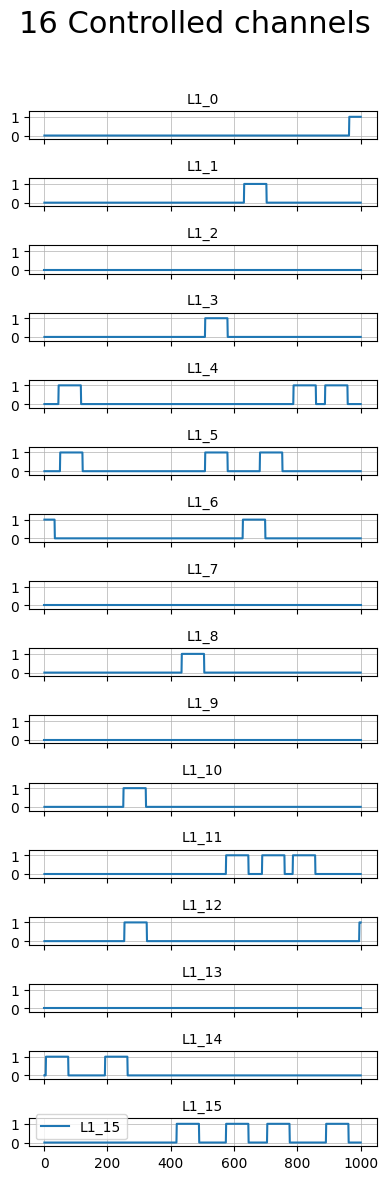

plot n°:  2
--------------------------------------------------------


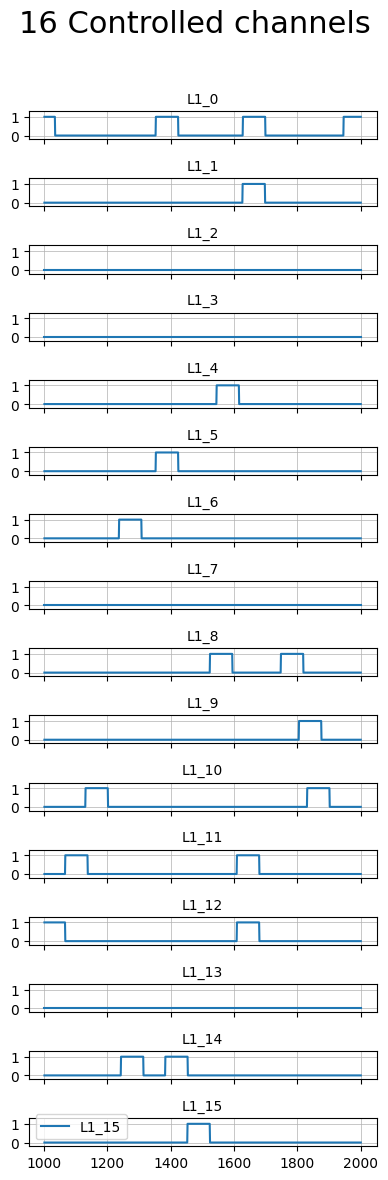

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f75d31434f0>>
Traceback (most recent call last):
  File "/home/shams/.virtualenvs/Research with Dr Ilya/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [71]:
"""Compiler """

t_axis = np.array([0]) #This is the general time axis that is common for all channels
amps, wave_counts, conds= [], [], []  #the conditions that help track the progression of the signals using the classes

for i in range(n_of_plots): #this creates elements from the classes to keep track of the progression of the waveforms

    amps.append([rand_memory() for i in range(n_signals)])
    wave_counts.append([markers() for i in range(n_signals)])
    conds.append([conditions() for i in range(n_signals)])

#l_s and l_1s are lists that hold the binary values for the trigger L states
L_s=[]
for i in range (7):
    L_s.append(np.array([]))

L_1s=[]
for i in range(16):
    L_1s.append(np.array([]))

signals=[] #generate empty arrays for the different channels
for i in range(n_of_plots):
    signals.append(np.array([0]))


#while True:
for i in range(1+ plot_size* 5 ): #choosing the number of plots to plot, replace by while True to keep going until stopped

    t_axis= smart_append(t_axis, t_axis, t_axis[-1]+1, max_size-1) #adds +1 to time each cycle, and limits the len(t_axis) to max_size


    for n in range(n_of_plots): #this generates signals for the different channels
        Information = random_generator(mean, std_dev, conds[n], wave_counts[n], amps[n], likelihood, n_signals, signal_limit)
        signals[n] = smart_append(t_axis, signals[n], Information, max_size)

    #there are two blocks of code in here

    #block 1 for plotting L2 - L4 states
    # comment out the block needed for the desired trigger plots, also choose to save or show the plots
    L_states=L_Triggers(signals, L1, L1_counters, threshold, delay_period,L2,L2_level,L3,L4, Groups)

    for i in range (7):
        L_s[i]=smart_append(t_axis,L_s[i],L_states[i],max_size)

    plot_L_states(t_axis,L_s, L_name, plot_size,"show") #choose "save" or "show" for plot options /default is show

    """
    #block 2 for plotting only L1 states
    L1s=L1_Triggers_returns(signals, L1, L1_counters, threshold, delay_period)

    for i in range (16):
        L_1s[i]=smart_append(t_axis,L_1s[i],L1s[i],max_size)
    plot_L_states(t_axis,L_1s, L1_names, plot_size,"show") #choose "save" or "show" for plot options /default is show
    """
    #if there are some issues with the trigger, go back to the cell where L1, L2, L3 and L4 are defined and reset them


    #this function displays the waveforms
    #display_n_plots(t_axis, signals, n_of_plots, threshold, plot_size) #function to plot the channels
    time.sleep(0.000001) #delay condition to help prevent oveloading the processor/ not sure how helpful this is

print("Done!")


In [52]:
lis=[L1[i].state for i in range(16)]
print(lis)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
